# Обучение эмбеддингов (Metric Learning)

## `Задание:`
    Обучить сиамскую сеть для верификации лиц на датасете LFW
    Библиотеки: [Python, Tensorflow]



## Переключение версии TensorFlow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds


2021-12-23 20:15:46.738568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 20:15:46.738624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Загрузка и подготовка датасета LFW

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)



2021-12-23 20:15:50.433982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-23 20:15:50.434032: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 20:15:50.434067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2021-12-23 20:15:50.437269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_ds

<PrefetchDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [4]:
print(f'Строк в датасете:\n\t train - {len(train_ds)}\n\t test - {len(test_ds)}')

Строк в датасете:
	 train - 11910
	 test - 1323


## Визуализация датасета LFW

2021-12-23 20:15:51.663461: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


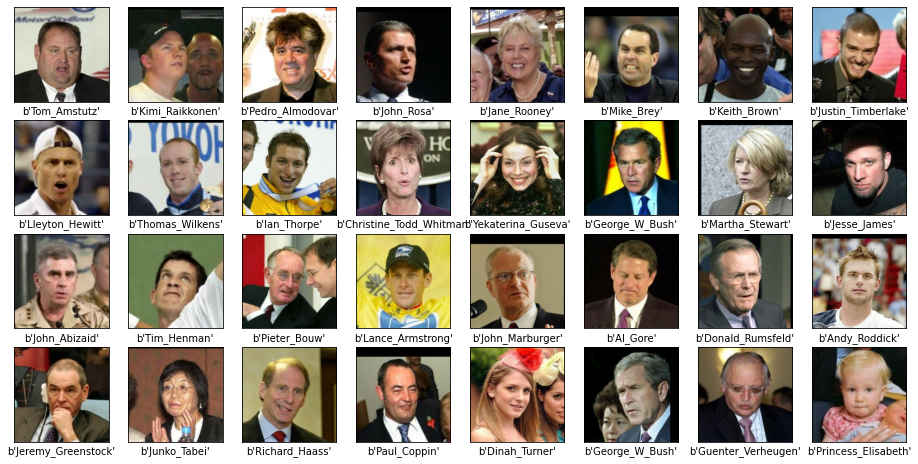

In [5]:
ds = train_ds.take(32)

fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(str(label))
    j += 1
plt.show()

## Создание модели CNN

In [6]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])


## Contrastive Loss

In [7]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    """  На вход подаются батчи эмбедингов и метки
    embs - батчи
    labels - метки"""
    bs = embs.shape[0]
    # разбитие батча эмбедингов и меток на пары
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)



## Подготовка пайплайна данных

In [8]:
INP_SIZE = 256
BATCH_SIZE = 64
NUM_EPOCHS = 3

def prepare_img(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare_img)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=len(test_ds))
test_ds = test_ds.map(prepare_img)
test_ds = test_ds.repeat(NUM_EPOCHS)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)



## Подготовка к обучению

In [9]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [10]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
        


[0] Loss: 89.48908996582031
[200] Loss: 0.03486403450369835
[400] Loss: 0.13990765810012817
CPU times: user 5h 55min 33s, sys: 19min 45s, total: 6h 15min 19s
Wall time: 2h 2min 6s


### Сохранение/Загрузка модели

In [11]:
# Загрузка
# model= tf.saved_model.load('./models/')

# Сохранение
tf.saved_model.save(model, './models/3/')

2021-12-23 22:18:00.472073: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/3/assets


INFO:tensorflow:Assets written to: ./models/3/assets


In [13]:
%%time

person_emb_train = model.predict(train_ds)

CPU times: user 1h 30min 57s, sys: 2min 26s, total: 1h 33min 23s
Wall time: 43min 34s


In [12]:
# посмотрим метки
for iteration, (images, labels) in enumerate(train_ds):
    if iteration != 0:
        break
    print(labels)

tf.Tensor(
[b'Elvis_Stojko' b'Donald_Rumsfeld' b'Stockard_Channing' b'Dick_Vermeil'
 b'Robert_Zoellick' b'Sonia_Lopez' b'Rick_Perry' b'Helen_Clark'
 b'Colin_Powell' b'Charles_Mathews' b'Ludivine_Sagnier' b'Kostya_Tszyu'
 b'Colin_Farrell' b'Serge_Tchuruk' b'William_Ford_Jr'
 b'Christine_Baumgartner' b'Jacqueline_Obradors' b'Ralph_Klein'
 b'Paul_Wolfowitz' b'Don_Nickles' b'Derrick_Rodgers' b'Carolina_Moraes'
 b'Brad_Garrett' b'John_Ashcroft' b'Richard_Rodriguez' b'Bill_Clinton'
 b'Sarah_Jessica_Parker' b'Lance_Armstrong' b'Jorge_Batlle' b'Don_King'
 b'Colin_Powell' b'Steve_Lavin' b'Tony_Blair' b'Juan_Ignacio_Chela'
 b'Igor_Ivanov' b'Jacques_Chirac' b'Tony_Blair' b'Tim_Henman'
 b'Kathleen_Kennedy_Townsend' b'Jacques_Chirac' b'Taufik_Kiemas'
 b'Drew_Barrymore' b'Asa_Hutchinson' b'Colin_Powell' b'Rina_Lazo'
 b'Bob_Wright' b'Kim_Ryong-sung' b'Jesse_Jackson' b'John_Allen_Muhammad'
 b'Chris_Terry' b'Mike_Miller' b'Winona_Ryder' b'Roberto_Carlos'
 b'Charles_Taylor' b'Ryan_Goodman' b'Dorothy_Lam

## Получение эмбеддингов для тестовой выборки

In [26]:
test_images, test_labels = next(iter(test_ds))

In [28]:
test_labels

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'Gerald_Barbarito', b'Alvaro_Uribe', b'Laura_Bush',
       b'Mark_Philippoussis', b'Ariel_Sharon', b'Horace_Newcomb',
       b'Jon_Gruden', b'Keira_Knightley', b'John_Salazar',
       b'Cate_Blanchett', b'Winona_Ryder', b'Robert_Redford',
       b'Matthew_Perry', b'Serena_Williams', b'Arnold_Schwarzenegger',
       b'Catherine_Ndereba', b'Elvis_Costello', b'Princess_Caroline',
       b'Colin_Powell', b'Jiri_Novak', b'Lawrence_Roberts',
       b'Dionyssis_Georgiadis', b'Hermann_Maier', b'Vladimir_Putin',
       b'Yao_Ming', b'Donald_Rumsfeld', b'James_Hallock', b'Shimon_Peres',
       b'Toni_Braxton', b'Michael_Schumacher', b'Hugh_Grant',
       b'Diana_Krall', b'Heizo_Takenaka', b'David_Beckham',
       b'George_W_Bush', b'Hamid_Karzai', b'Thierry_Falise',
       b'Naomi_Watts', b'Justin_Leonard', b'Colin_Powell',
       b'Gerhard_Schroeder', b'Zinedine_Zidane', b'David_Wells',
       b'Valerie_Harper', b'Ricardo_Maduro', b'Monica_L

In [29]:
test_embs = model(test_images)
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)


/home/oleg_rev/anaconda3/envs/DL_env3_9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/oleg_rev/anaconda3/envs/DL_env3_9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [81]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


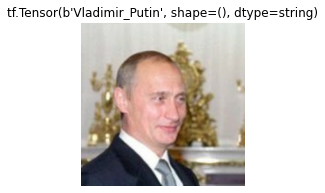

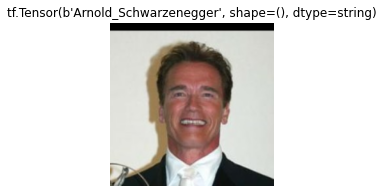

In [82]:
for i in [23, 14]:
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.imshow(test_images[i])
    plt.title(test_labels[i])
    plt.axis('off')

In [83]:
Vladimir_Putin = test_embs_2D[23]
Arnold_Schwarzenegger = test_embs_2D[14] 
print('Vladimir_Putin - Vladimir_Putin: '
      , diff(Vladimir_Putin, Vladimir_Putin))
print('Vladimir_Putin - Arnold_Schwarzenegger: '
      , diff(Vladimir_Putin, Arnold_Schwarzenegger))

Vladimir_Putin - Vladimir_Putin:  0.0
Vladimir_Putin - Arnold_Schwarzenegger:  28.101033625479197


## Тестирование на новых данных

In [105]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    # img = (1. - img).astype(np.float32)
    # img = np.mean(img, axis=2)
    # img = np.reshape(img, (INP_SIZE, INP_SIZE, 1))
    return img


In [125]:
img_a1 = load_and_prepare_image('./imgs_new/putin1.jpeg')
img_a2 = load_and_prepare_image('./imgs_new/putin3.jpeg')
img_b1 = load_and_prepare_image('./imgs_new/biden.jpeg')

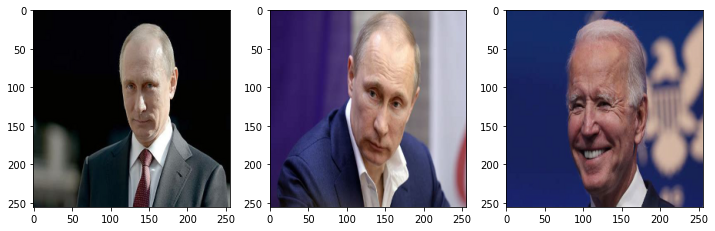

In [126]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)

plt.show()

## Получение эмбеддингов для новых данных

In [127]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

In [128]:
emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A1: ', diff(emb1, emb1))
print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A1:  0.0
A1 <-> A2:  17.71143891273024
A1 <-> B1:  18.341961489151895
